# Comparing 3 Graph Alignment Implementations

In [2]:
from graphcuda import generate_random_adjacency_matrix

from faqap import minimize
import wlalign
from graspologic.match import graph_match
import numpy as np
from numba import cuda
import math
import time
from tqdm import tqdm

c:\Users\Anderson\miniconda3\envs\gnn\lib\site-packages\graspologic\models\edge_swaps.py:215: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  _edge_swap_numba = nb.jit(_edge_swap, nopython=False)


In [3]:
n_nodes = 1000
prob_edge = 1.2/(100-1)

A = generate_random_adjacency_matrix(n_nodes, prob_edge)
B = generate_random_adjacency_matrix(n_nodes, prob_edge)

frob_norm = np.linalg.norm(A - B)
print(f'Frobenius Norm between graphs A, B: {frob_norm:.02f}')

Frobenius Norm between graphs A, B: 3615.32


In [4]:
n_runs = 10

## FAQAP

In [338]:
avg_time_faqap = 0
avg_norm_faqaq = 0

for _ in tqdm(range(n_runs), position=0, desc='N', leave=False, ncols=100):
    start = time.perf_counter()
    perm = minimize(A, B, descents_count=1).x
    end = time.perf_counter()
    avg_time_faqap += end - start

    P = np.zeros_like(A)
    P[perm, np.arange(len(A))] = 1

    B_perm = P.T @ B @ P

    frob_norm_faqap = np.linalg.norm(A - B_perm)
    avg_norm_faqaq += frob_norm_faqap
    
avg_time_faqap /= n_runs
avg_norm_faqaq /= n_runs

print(f'Frobenius Norm from FAQAP: {avg_norm_faqaq:.02f}')
print(f'\tin {avg_time_faqap:.4f}s')

Frobenius Norm from FAQAP: 3711.97
	in 2.9460s


## Graspologic

In [344]:
avg_time_grasp = 0
avg_norm_grasp = 0

for _ in tqdm(range(n_runs), position=0, desc='N', leave=False, ncols=100):
    start = time.perf_counter()
    perm = graph_match(A, B, max_iter=30, rng=42)
    end = time.perf_counter()
    avg_time_grasp += end - start

    P = np.zeros_like(A)
    P[perm.indices_B, np.arange(len(A))] = 1

    B_perm = P.T @ B @ P

    frob_norm_grasp = np.linalg.norm(A - B_perm)
    avg_norm_grasp += frob_norm_grasp

avg_time_grasp /= n_runs
avg_norm_grasp /= n_runs

print(f'Frobenius Norm from Graspologic: {avg_norm_grasp:.02f}')
print(f'\tin {avg_time_grasp:.4f}s')

Frobenius Norm from Graspologic: 1988.62
	in 11.7364s


## WL-Align

In [340]:
avg_time_wlalign = 0
avg_norm_wlalign = 0

for _ in tqdm(range(n_runs), position=0, desc='N', leave=False, ncols=100):
    start = time.perf_counter()
    alignment = wlalign.wl_align(A, B, k=2, l=2)
    end = time.perf_counter()
    avg_time_wlalign += end - start
    P = np.zeros_like(A)
    P[alignment.T[0], alignment.T[1]] = 1

    B_perm = P.T @ B @ P

    frob_norm_wlalign = np.linalg.norm(A - B_perm)
    avg_norm_wlalign += frob_norm_wlalign

avg_time_wlalign /= n_runs
avg_norm_wlalign /= n_runs

print(f'Frobenius Norm from WLALIGN: {avg_norm_wlalign:.02f}')
print(f'\tin {avg_time_wlalign:.4f}s')

Frobenius Norm from WLALIGN: 3716.53
	in 24.2599s


# Faster Graph Alignment

In [341]:
from scipy.sparse import csr_array
from scipy.optimize import linear_sum_assignment

## Bare-bones Graspologic Implementation

In [347]:
# only A_nn, B_nn are non-zero
# perm_A = np.arange(n_nodes)
# perm_B = np.arange(n_nodes)
# no need to perm
def lsa(P: np.ndarray, rng: np.random.Generator, n_nodes) -> np.ndarray:
    row_perm = rng.permutation(n_nodes)
    undo_row_perm = np.argsort(row_perm)
    P_perm = P[row_perm]
    _, permutation = linear_sum_assignment(P_perm, maximize=True)
    permutation = permutation[undo_row_perm]
    return permutation

rng = np.random.default_rng(42)
tol = 0.03

start = time.perf_counter()
P = np.full((n_nodes, n_nodes), 1 / n_nodes)
for n in tqdm(range(10), position=0, desc='N', leave=False, ncols=100):
    gradient = A @ P @ B.T + A.T @ P @ B

    # Linear sum assignment
    permutation = lsa(gradient, rng, n_nodes)

    # Compute step direction
    Q = np.eye(n_nodes)[permutation]

    # Compute alpha
    R = P - Q
    AR = A @ R
    RB = R @ B
    a = (AR * RB).sum()
    b = ((A @ Q) * RB).sum() + (AR * (Q @ B)).sum()
    
    if -a > 0 and 0 <= -b / (2 * a) <= 1:
        alpha = -b / (2 * a)
    else:
        alpha = float(np.argmin([0, -(b + a)]))

    # Take step in direction
    P_new = alpha * P + (1 - alpha) * Q

    # Converged?
    if np.linalg.norm(P - P_new) / np.sqrt(n_nodes) < tol:
        P = P_new
        break

    P = P_new

# Finalize
permutation = lsa(P, rng, n_nodes)
end = time.perf_counter()

P = np.zeros_like(A)
P[permutation, np.arange(len(A))] = 1

B_perm = P.T @ B @ P

frob_norm_faster = np.linalg.norm(A - B_perm)
print(end - start)
frob_norm_faster

3.864244399999734


2246.5126760943713

## GPU-Accelerated bare-bones

In [348]:
import cupy

def lsa(P: cupy.ndarray, rng: np.random.Generator, n_nodes) -> np.ndarray:
    row_perm = rng.permutation(n_nodes)
    undo_row_perm = cupy.argsort(row_perm)
    P_perm = cupy.asnumpy(P[row_perm])
    _, permutation = linear_sum_assignment(P_perm, maximize=True)
    permutation = permutation[undo_row_perm]
    return permutation

rng = np.random.default_rng(42)
tol = 0.03
A_gpu = cupy.array(A)
B_gpu = cupy.array(B)
start = time.perf_counter()
P = cupy.full((n_nodes, n_nodes), 1 / n_nodes)
for n in tqdm(range(10), position=0, desc='N', leave=False, ncols=100):
    gradient = A_gpu @ P @ B_gpu.T + A_gpu.T @ P @ B_gpu

    # Linear sum assignment
    permutation = lsa(gradient, rng, n_nodes)

    # Compute step direction
    Q = cupy.eye(n_nodes)[permutation]

    # Compute alpha
    R = P - Q
    AR = A_gpu @ R
    RB = R @ B_gpu
    a = (AR * RB).sum()
    b = ((A_gpu @ Q) * RB).sum() + (AR * (Q @ B_gpu)).sum()
    
    if -a > 0 and 0 <= -b / (2 * a) <= 1:
        alpha = -b / (2 * a)
    else:
        alpha = float(np.argmin([0, -(cupy.asnumpy(b) + cupy.asnumpy(a))]))

    # Take step in direction
    P_new = alpha * P + (1 - alpha) * Q

    # # Converged?
    # if cupy.linalg.norm(P - P_new) / cupy.sqrt(n_nodes) < tol:
    #     P = P_new
    #     break

    P = P_new

# Finalize
permutation = lsa(P, rng, n_nodes)
end = time.perf_counter()

P = cupy.zeros_like(A)
P[permutation, cupy.arange(len(A))] = 1

B_perm = P.T @ B_gpu @ P

frob_norm_faster = cupy.linalg.norm(A_gpu - B_perm)
print(end - start)
frob_norm_faster

1.92087249999895


array(2246.51024054)

In [ ]:
n_nodes = 1000
prob_edge = 1.2/(100-1)

A = generate_random_adjacency_matrix(n_nodes, prob_edge)
B = generate_random_adjacency_matrix(n_nodes, prob_edge)

frob_norm = np.linalg.norm(A - B)
print(f'Frobenius Norm between graphs A, B: {frob_norm:.02f}')

In [ ]:

avg_time_grasp += end - start

P = np.zeros_like(A)
P[perm.indices_B, np.arange(len(A))] = 1

B_perm = P.T @ B @ P

frob_norm_grasp = np.linalg.norm(A - B_perm)
avg_norm_grasp += frob_norm_grasp

In [7]:
from graphcuda import faq_align

nodes = [100, 500, 1000, 1500, 2000, 3000, 4000]

faq_times = []
for n_nodes in tqdm(nodes):
    prob_edge = 1.2/(100-1)

    A = generate_random_adjacency_matrix(n_nodes, prob_edge)
    B = generate_random_adjacency_matrix(n_nodes, prob_edge)


    start = time.perf_counter()
    B_aligned = faq_align(A, B)
    end = time.perf_counter()
    faq_times.append(end - start)


100%|██████████| 7/7 [04:47<00:00, 41.14s/it]


In [8]:
nodes = [100, 500, 1000, 1500, 2000, 3000, 4000]

grasp_times = []
for n_nodes in tqdm(nodes):
    prob_edge = 1.2/(100-1)

    A = generate_random_adjacency_matrix(n_nodes, prob_edge)
    B = generate_random_adjacency_matrix(n_nodes, prob_edge)


    start = time.perf_counter()
    B_aligned = graph_match(A, B, max_iter=30, rng=42)
    end = time.perf_counter()
    grasp_times.append(end - start)

100%|██████████| 7/7 [12:56<00:00, 110.96s/it]


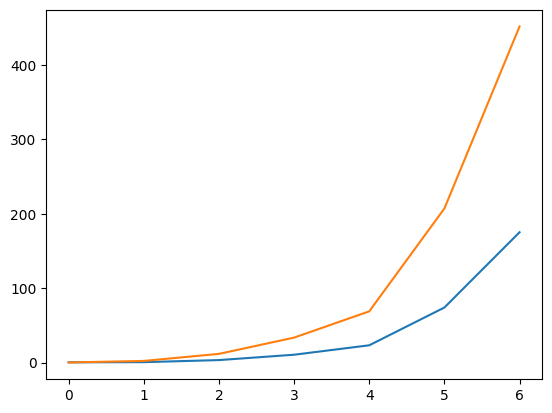

In [10]:
import matplotlib.pyplot as plt
plt.plot(faq_times, label='FAQ')
plt.plot(grasp_times, label="GRASP")

In [11]:
np.array(grasp_times) / np.array(faq_times)

array([0.32736128, 3.96362599, 3.51731615, 3.18552294, 2.96596472,
       2.79925283, 2.57920132])

In [ ]:
grasp_t = 0
faq_t = 0

prob_edge = 1.2/(100-1)
n_nodes = 5000

A = generate_random_adjacency_matrix(n_nodes, prob_edge)
B = generate_random_adjacency_matrix(n_nodes, prob_edge)

start = time.perf_counter()
B_aligned = graph_match(A, B, max_iter=30, rng=42)
end = time.perf_counter()

start = time.perf_counter()
B_aligned = faq_align(A, B)
end = time.perf_counter()